# MNIST Transformer (Explicit Attention)

**Topic focus:** self-attention mechanics + residual connections + Layer Normalization  
**Not emphasized today:** positional embeddings (kept for completeness, but we won’t dwell on them). We will go through it next week.

---

## What students will do
You will train a small Transformer on MNIST and then run **controlled ablations** (model “surgery”) to understand why Transformers include:
- **Scaled dot-product attention** (the $1/\sqrt{d}$ factor)
- **Residual connections**
- **LayerNorm**

At the end, you will answer short questions and compare outcomes.

---

## Key idea: turning an image into a sequence
MNIST images are `28×28`. Transformers expect **sequences of tokens**.

In this notebook we represent each image as a sequence of **28 tokens**:
- Token = **one row** of pixels
- Each token has **28 features** (pixel intensities in that row)

So an image tensor of shape:

- `[B, 1, 28, 28]`  (batch, channel, height, width)

becomes

- `[B, 28, 28]`  (batch, tokens, features)

Then each token is embedded from 28 → `d_model`.

---

## Outputs you will monitor
- Test accuracy after 5 epochs (quick comparisons)
- Gradient norm (rough stability indicator)
- Attention heatmaps and attention entropy (how “peaky” attention is)


In [1]:
# =====================================
# 0) Imports and device setup
# =====================================
# If you're in Google Colab:
# Runtime -> Change runtime type -> GPU (optional but faster)

import math
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

print("PyTorch version:", torch.__version__)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


PyTorch version: 2.10.0
Using device: cuda


## 1) Load MNIST (with normalization)

### Why normalize?
Neural nets train more reliably when input features are:
- roughly **zero-centered**
- roughly **same scale**

`Normalize(mean, std)` applies:
\[ x_{norm} = \frac{x - \mu}{\sigma} \]

For MNIST (after `ToTensor()` scales pixels to `[0,1]`), common dataset statistics are:
- mean ≈ 0.1307
- std ≈ 0.3081


In [18]:
# =====================================
# 1) Dataset and DataLoaders
# =====================================
# num_workers controls how many CPU processes load/transform data in parallel.
# pin_memory=True can speed up CPU->GPU transfers when using CUDA.

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

train_loader = DataLoader(
    train_dataset, batch_size=128, shuffle=True,
    num_workers=8, pin_memory=torch.cuda.is_available()
)
test_loader = DataLoader(
    test_dataset, batch_size=256, shuffle=False,
    num_workers=2, pin_memory=torch.cuda.is_available()
)

print("Train size:", len(train_dataset), "| Test size:", len(test_dataset))


Train size: 60000 | Test size: 10000


## 2) Lab switches (for ablations)

We will flip these switches to run practical experiments **without rewriting the model**.

- `use_scale`: include/remove $1/\sqrt{d}$ in attention scores (Exercise 2)
- `use_layernorm`: include/remove LayerNorm (Exercise 3)
- `use_residual`: include/remove residual connections (Exercise 4)
- `use_manual_ln`: swap `nn.LayerNorm` with a manual implementation (Exercise 5)

> Tip for class: ask students to **predict** what will happen before running each experiment.


In [3]:
# =====================================
# 2) Experiment toggles (edit these)
# =====================================
CFG = {
    "use_scale": True,
    "use_layernorm": True,
    "use_residual": True,
    "use_manual_ln": False,
    "dropout": 0.1
}
print("Current config:", CFG)


Current config: {'use_scale': True, 'use_layernorm': True, 'use_residual': True, 'use_manual_ln': False, 'dropout': 0.1}


## 3) Manual LayerNorm (to understand the math)

PyTorch provides `nn.LayerNorm`, but to understand what it does, we implement it ourselves.

LayerNorm normalizes **features within each token**, not across the batch.

Given x shaped `[B, T, D]`, for each `(B, T)` position we compute mean/variance over `D`:

$
\mu = \text{mean}(x,\; \text{over features}) \quad
\sigma^2 = \text{var}(x,\; \text{over features})
$

$
\hat{x} = \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}}
$

Then apply learnable scale/shift:  
$
y = \gamma \hat{x} + \beta
$

This is exactly what `nn.LayerNorm(D)` does.


In [4]:
# =====================================
# 3) Manual LayerNorm (matches nn.LayerNorm behavior)
# =====================================
class ManualLayerNorm(nn.Module):
    """Manual LayerNorm over the last dimension (features)."""
    def __init__(self, dim: int, eps: float = 1e-5):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(dim))  # scale
        self.beta  = nn.Parameter(torch.zeros(dim)) # shift
        self.eps = eps

    def forward(self, x: torch.Tensor):
        # x: [B, T, D]
        mean = x.mean(dim=-1, keepdim=True)                 # [B, T, 1]
        var  = x.var(dim=-1, keepdim=True, unbiased=False)  # [B, T, 1]
        x_norm = (x - mean) / torch.sqrt(var + self.eps)    # [B, T, D]
        return self.gamma * x_norm + self.beta


## 4) Explicit single-head self-attention (core concept)

Self-attention turns a sequence `x` (`[B, T, D]`) into another sequence of the same shape.

### Step-by-step math
We compute:
- Queries:  $Q = W_q \mathbf{x}$
- Keys:     $K = W_k \mathbf{x}$
- Values:   $V = W_v \mathbf{x}$

Then attention scores:
$
S = QK^T
$

Scaled dot-product attention uses:
$
S = \frac{QK^T}{\sqrt{D}}
$

Then softmax row-wise to get attention weights (a distribution over keys for each query):
$
A = \text{softmax}(S)
$

Finally:
$
\text{Attended} = AV
$

We return:
- output sequence `[B, T, D]`
- attention matrix `[B, T, T]` (so we can visualize it)


In [5]:
# =====================================
# 4) Explicit attention (single-head)
# =====================================
class SelfAttention(nn.Module):
    """Single-head explicit scaled dot-product attention."""
    def __init__(self, d_model: int, use_scale: bool = True):
        super().__init__()
        self.d_model = d_model
        self.use_scale = use_scale

        # Linear maps to produce Q, K, V from x
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)

        # Output projection
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, x: torch.Tensor):
        # x: [B, T, D]
        Q = self.W_q(x)  # [B, T, D]
        K = self.W_k(x)  # [B, T, D]
        V = self.W_v(x)  # [B, T, D]

        # scores[b] = Q[b] @ K[b]^T  -> [T, T]
        scores = torch.matmul(Q, K.transpose(-2, -1))  # [B, T, T]

        # Optional scaling (Exercise 2)
        if self.use_scale:
            scores = scores / math.sqrt(self.d_model)

        # Softmax over keys dimension: each query row sums to 1
        attn_weights = torch.softmax(scores, dim=-1)   # [B, T, T]

        # Weighted sum of values
        attended = torch.matmul(attn_weights, V)       # [B, T, D]

        # Final projection
        out = self.W_o(attended)                       # [B, T, D]

        return out, attn_weights


## 5) Transformer block = Attention + MLP, with Residual + LayerNorm

A typical Transformer block has two sublayers:

1) **Attention sublayer**
- attention(x)
- residual add (skip connection): `x + attention(x)`
- layer norm

2) **Feed-forward (MLP) sublayer**
- MLP(x)
- residual add: `x + MLP(x)`
- layer norm

### Why these pieces matter
- **Residuals** help gradients flow through deep networks.
- **LayerNorm** keeps activation scales stable during training.
- **Scaling** in attention prevents softmax from saturating.


In [6]:
# =====================================
# 5) Transformer block with ablation switches
# =====================================
class TransformerBlock(nn.Module):
    def __init__(self, d_model: int, mlp_hidden: int, dropout: float = 0.0,
                 use_layernorm: bool = True, use_residual: bool = True,
                 use_manual_ln: bool = False, use_scale: bool = True):
        super().__init__()
        self.use_layernorm = use_layernorm
        self.use_residual = use_residual

        self.attn = SelfAttention(d_model, use_scale=use_scale)

        # Choose LayerNorm implementation
        if use_manual_ln:
            self.norm1 = ManualLayerNorm(d_model)
            self.norm2 = ManualLayerNorm(d_model)
        else:
            self.norm1 = nn.LayerNorm(d_model)
            self.norm2 = nn.LayerNorm(d_model)

        # Simple MLP (feed-forward network)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, mlp_hidden),
            nn.ReLU(),
            nn.Linear(mlp_hidden, d_model)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor):
        # ---- Attention sublayer ----
        attn_out, attn_weights = self.attn(x)          # attn_out: [B, T, D]
        attn_out = self.dropout(attn_out)

        # Residual connection (Exercise 4 toggles this)
        if self.use_residual:
            x = x + attn_out
        else:
            x = attn_out

        # LayerNorm (Exercise 3 toggles this)
        if self.use_layernorm:
            x = self.norm1(x)

        # ---- MLP sublayer ----
        mlp_out = self.mlp(x)
        mlp_out = self.dropout(mlp_out)

        if self.use_residual:
            x = x + mlp_out
        else:
            x = mlp_out

        if self.use_layernorm:
            x = self.norm2(x)

        return x, attn_weights


## 6) MNISTTransformer: converting images to sequences

Input image batch has shape `[B, 1, 28, 28]`.
- `x.squeeze(1)` removes the channel → `[B, 28, 28]`
- Interpret as: `T=28 tokens` (rows), each token has `28 features`

Then we embed each token from 28 → `d_model` using a linear layer.  
After that, the Transformer block operates on `[B, T, d_model]`.

Finally, we average over tokens (rows) and classify.


In [7]:
# =====================================
# 6) MNIST Transformer model
# =====================================
class MNISTTransformer(nn.Module):
    def __init__(self, seq_len: int = 28, input_dim: int = 28,
                 d_model: int = 64, mlp_hidden: int = 128,
                 num_classes: int = 10, dropout: float = 0.0,
                 use_scale: bool = True, use_layernorm: bool = True,
                 use_residual: bool = True, use_manual_ln: bool = False):
        super().__init__()
        self.seq_len = seq_len
        self.d_model = d_model

        # Embed each row (28 pixel values) into a d_model-dimensional token vector
        self.input_proj = nn.Linear(input_dim, d_model)

        # Positional embeddings (kept, but not emphasized)
        self.pos_embed = nn.Parameter(torch.randn(1, seq_len, d_model) * 0.02)

        self.block = TransformerBlock(
            d_model=d_model, mlp_hidden=mlp_hidden, dropout=dropout,
            use_layernorm=use_layernorm, use_residual=use_residual,
            use_manual_ln=use_manual_ln, use_scale=use_scale
        )

        # Final classifier maps pooled representation -> 10 classes
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x: torch.Tensor):
        '''
        x: [B, 1, 28, 28]
        returns:
          logits: [B, 10]
          attn_weights: [B, 28, 28]
        '''
        # Convert image to sequence of row-tokens
        x = x.squeeze(1)          # [B, 28, 28]

        # Embed each row-token
        x = self.input_proj(x)    # [B, 28, d_model]

        # Add positional embedding (not a focus today)
        x = x + self.pos_embed    # [B, 28, d_model]

        # Transformer block
        x, attn_weights = self.block(x)

        # Pool tokens into a single vector (global average pooling over rows)
        x = x.mean(dim=1)         # [B, d_model]

        # Classify
        logits = self.classifier(x)  # [B, 10]
        return logits, attn_weights


## 7) Training and evaluation utilities

We train with cross-entropy loss for MNIST digit labels.

We also print an approximate **gradient norm** each epoch. If training becomes unstable, gradient norms can grow a lot.


In [8]:
# =====================================
# 7) Train/Eval helpers + gradient norm monitor
# =====================================
def grad_global_norm(model: nn.Module) -> float:
    """Rough stability signal: sum of parameter gradient norms."""
    total = 0.0
    for p in model.parameters():
        if p.grad is not None:
            total += p.grad.detach().norm().item()
    return total

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss, total_correct, total_count = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits, _ = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item() * y.size(0)
        total_correct += (logits.argmax(dim=1) == y).sum().item()
        total_count += y.size(0)

    return total_loss / total_count, total_correct / total_count

def train(model, train_loader, test_loader, epochs=3, lr=1e-3, log_grads=True):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss, running_correct, running_count = 0.0, 0, 0
        last_gnorm = 0.0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad(set_to_none=True)
            logits, _ = model(x)
            loss = criterion(logits, y)
            loss.backward()

            if log_grads:
                last_gnorm = grad_global_norm(model)

            optimizer.step()

            running_loss += loss.item() * y.size(0)
            running_correct += (logits.argmax(dim=1) == y).sum().item()
            running_count += y.size(0)

        train_loss = running_loss / running_count
        train_acc = running_correct / running_count
        test_loss, test_acc = evaluate(model, test_loader)

        if log_grads:
            print(f"Epoch {epoch:02d} | Train loss {train_loss:.4f}, acc {train_acc:.4f} | "
                  f"Test loss {test_loss:.4f}, acc {test_acc:.4f} | GradNorm ~ {last_gnorm:.2f}")
        else:
            print(f"Epoch {epoch:02d} | Train loss {train_loss:.4f}, acc {train_acc:.4f} | "
                  f"Test loss {test_loss:.4f}, acc {test_acc:.4f}")


## 8) Attention visualization + “attention entropy”

The attention weights for one sample are a matrix `[T, T] = [28, 28]`.
- Row $i$ = distribution over keys attended by query token $i$
- If the matrix is very “peaky”, attention entropy is lower.

We compute an average entropy across all query rows:
$
H(A) = -\sum_j A_{ij}\log A_{ij}
$


In [9]:
import matplotlib.pyplot as plt

def attention_entropy(attn_mat: torch.Tensor, eps: float = 1e-12) -> float:
    """Entropy averaged over query rows. attn_mat: [T, T]."""
    p = attn_mat.clamp_min(eps)
    ent = -(p * p.log()).sum(dim=-1)   # [T]
    return ent.mean().item()

@torch.no_grad()
def show_attention_and_stats(model, loader, sample_index=0):
    model.eval()
    x, y = next(iter(loader))
    x, y = x.to(device), y.to(device)

    logits, attn = model(x)      # attn: [B, 28, 28]
    pred = logits.argmax(dim=1)

    attn_mat = attn[sample_index].detach().cpu()          # [28, 28]
    img = x[sample_index].detach().cpu().squeeze(0)       # [28, 28]

    print(f"Label: {y[sample_index].item()}  Pred: {pred[sample_index].item()}")
    print("Attention entropy (avg over rows):", round(attention_entropy(attn_mat), 4))

    # Which row is most 'attended to' overall? (average across queries)
    col_importance = attn_mat.mean(dim=0)   # [28]
    print("Most attended-to row index:", int(col_importance.argmax().item()))

    plt.figure()
    plt.title("MNIST Image")
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.show()

    plt.figure()
    plt.title("Attention Weights (28x28)")
    plt.imshow(attn_mat.numpy())
    plt.xlabel("Key row index")
    plt.ylabel("Query row index")
    plt.show()


# LAB: Exercises (≈ 1 hour total)

## Exercise 0 (5 min) — Baseline
Train with the default configuration and record:
- test accuracy after 5 epochs
- gradient norm trend (roughly stable or exploding?)

Then visualize attention for 1 sample.

---

## Exercise 1 (10 min) — Inspect attention on multiple samples
Run attention visualization for 4 different samples and record:
- label, prediction
- attention entropy
- most attended-to row

**Question:** do some digits have more focused attention (lower entropy)? Why?

---

## Exercise 2 (10 min) — Remove scaling ($1/\sqrt{d}$)
Set `use_scale=False`, retrain, and compare:
- training stability
- gradient norms
- attention entropy

**Question:** why does removing scaling often make attention too peaky?

---

## Exercise 3 (10 min) — Remove LayerNorm
Set `use_layernorm=False`, retrain, compare outcomes.

**Question:** what does LayerNorm control in the network?

---

## Exercise 4 (10 min) — Remove residual connections
Set `use_residual=False`, retrain, compare outcomes.

**Question:** why do residuals help optimization?

---

## Exercise 5 (10 min) — Replace LayerNorm with ManualLayerNorm
Set `use_manual_ln=True` (keep LayerNorm enabled but manual).

**Question:** should results match baseline? What would differences imply?


Epoch 01 | Train loss 0.8540, acc 0.7344 | Test loss 0.3405, acc 0.9023 | GradNorm ~ 8.83
Epoch 02 | Train loss 0.2872, acc 0.9140 | Test loss 0.2117, acc 0.9359 | GradNorm ~ 4.80
Epoch 03 | Train loss 0.2078, acc 0.9371 | Test loss 0.1644, acc 0.9485 | GradNorm ~ 3.29
Epoch 04 | Train loss 0.1665, acc 0.9484 | Test loss 0.1552, acc 0.9509 | GradNorm ~ 4.43
Epoch 05 | Train loss 0.1476, acc 0.9541 | Test loss 0.1291, acc 0.9578 | GradNorm ~ 3.69
Epoch 06 | Train loss 0.1290, acc 0.9601 | Test loss 0.1142, acc 0.9654 | GradNorm ~ 6.08
Epoch 07 | Train loss 0.1204, acc 0.9621 | Test loss 0.0933, acc 0.9707 | GradNorm ~ 4.26
Epoch 08 | Train loss 0.1088, acc 0.9664 | Test loss 0.0982, acc 0.9684 | GradNorm ~ 5.67
Epoch 09 | Train loss 0.1005, acc 0.9680 | Test loss 0.1026, acc 0.9671 | GradNorm ~ 4.29
Epoch 10 | Train loss 0.0938, acc 0.9701 | Test loss 0.1010, acc 0.9678 | GradNorm ~ 5.50
Label: 7  Pred: 7
Attention entropy (avg over rows): 2.4434
Most attended-to row index: 8


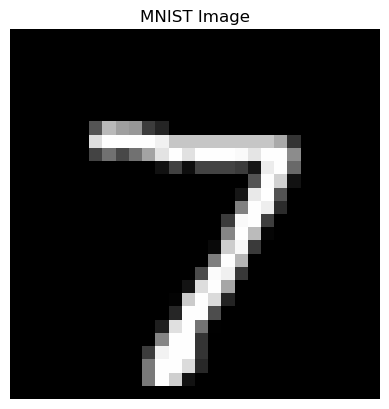

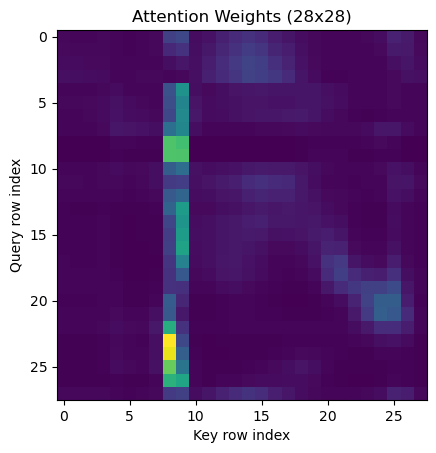

In [19]:
# =====================================
# Exercise 0: Baseline run
# =====================================
CFG = {
    "use_scale": True,
    "use_layernorm": True,
    "use_residual": True,
    "use_manual_ln": False,
    "dropout": 0.1
}

model_base = MNISTTransformer(
    d_model=64, mlp_hidden=128, dropout=CFG["dropout"],
    use_scale=CFG["use_scale"],
    use_layernorm=CFG["use_layernorm"],
    use_residual=CFG["use_residual"],
    use_manual_ln=CFG["use_manual_ln"]
)

train(model_base, train_loader, test_loader, epochs=10, lr=1e-3)
show_attention_and_stats(model_base, test_loader, sample_index=0)


Label: 0  Pred: 0
Attention entropy (avg over rows): 2.2908
Most attended-to row index: 5


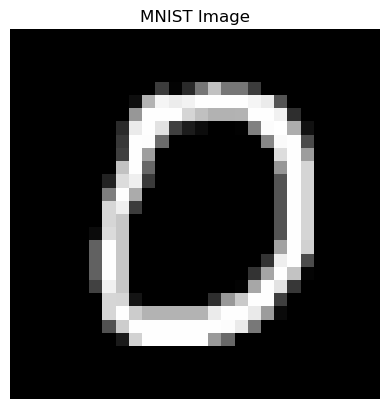

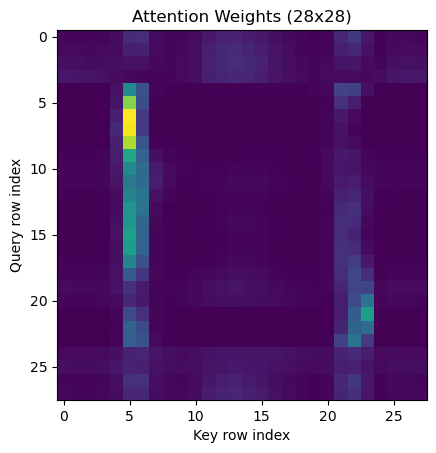

Label: 9  Pred: 9
Attention entropy (avg over rows): 2.2975
Most attended-to row index: 13


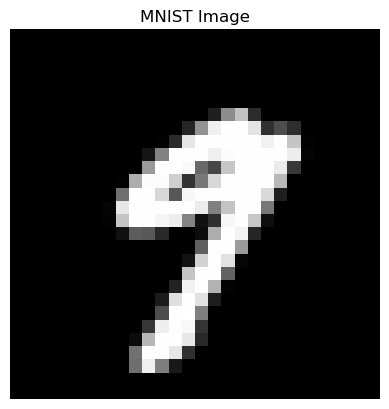

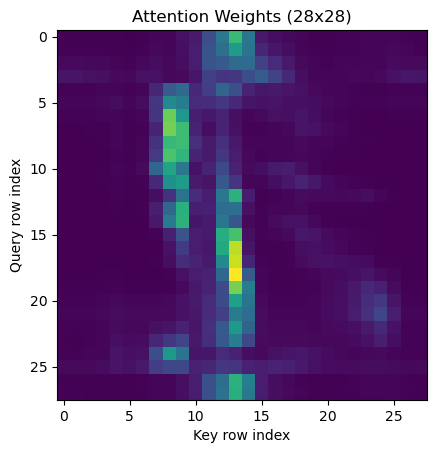

Label: 3  Pred: 3
Attention entropy (avg over rows): 2.2412
Most attended-to row index: 7


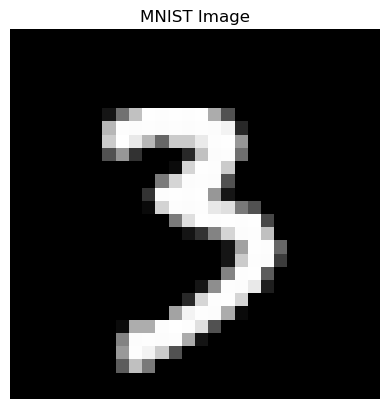

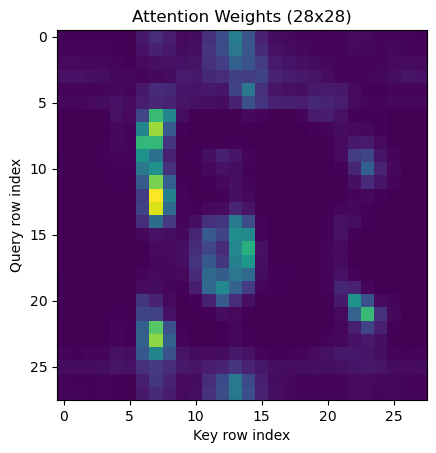

Label: 1  Pred: 1
Attention entropy (avg over rows): 3.1552
Most attended-to row index: 13


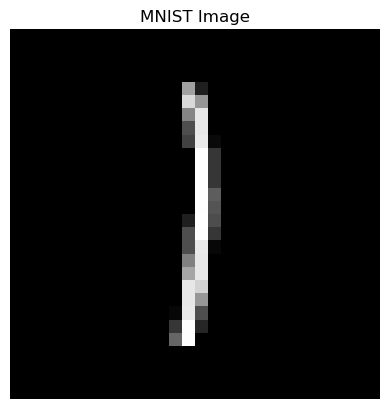

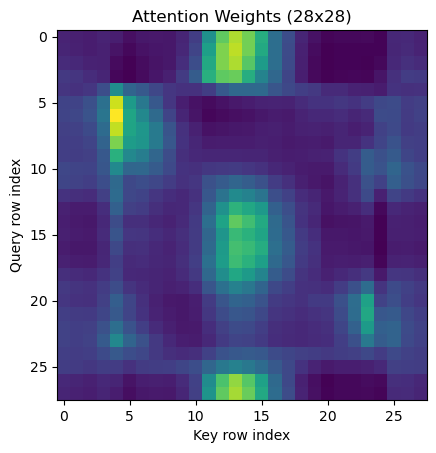

In [20]:
show_attention_and_stats(model_base, test_loader, sample_index=10)
show_attention_and_stats(model_base, test_loader, sample_index=20)
show_attention_and_stats(model_base, test_loader, sample_index=30)
show_attention_and_stats(model_base, test_loader, sample_index=40)


--- sample_index = 0 ---
Label: 7  Pred: 7
Attention entropy (avg over rows): 2.4434
Most attended-to row index: 8


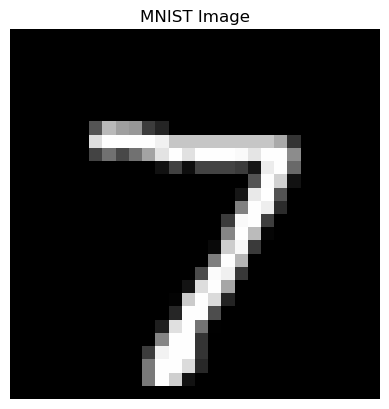

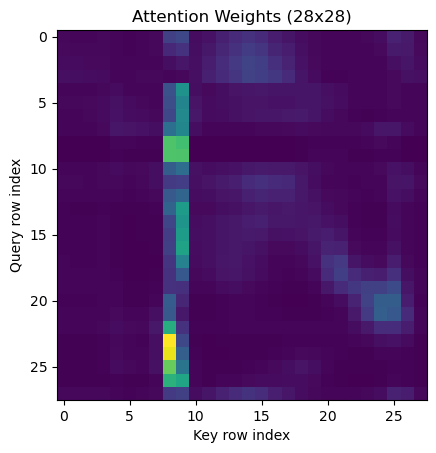


--- sample_index = 1 ---
Label: 2  Pred: 2
Attention entropy (avg over rows): 2.1816
Most attended-to row index: 20


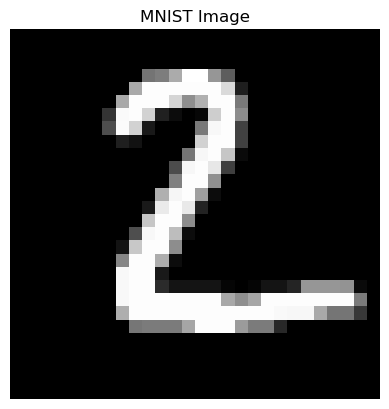

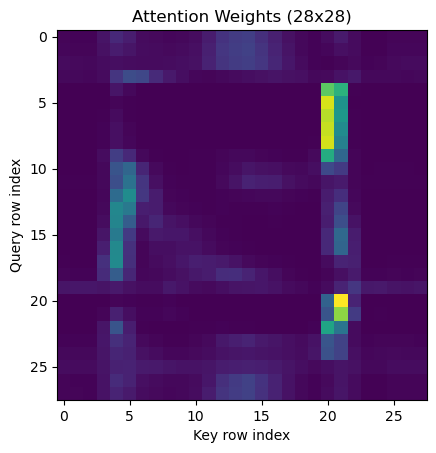


--- sample_index = 2 ---
Label: 1  Pred: 1
Attention entropy (avg over rows): 3.1384
Most attended-to row index: 13


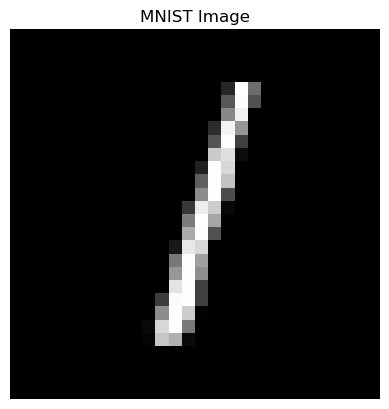

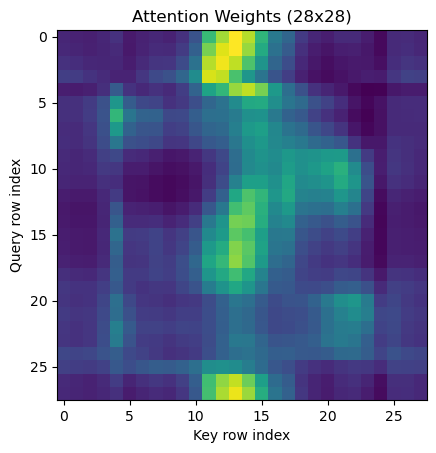


--- sample_index = 3 ---
Label: 0  Pred: 0
Attention entropy (avg over rows): 2.5064
Most attended-to row index: 8


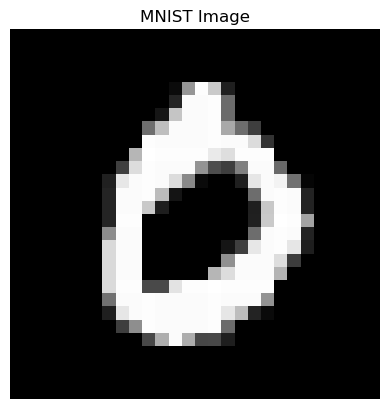

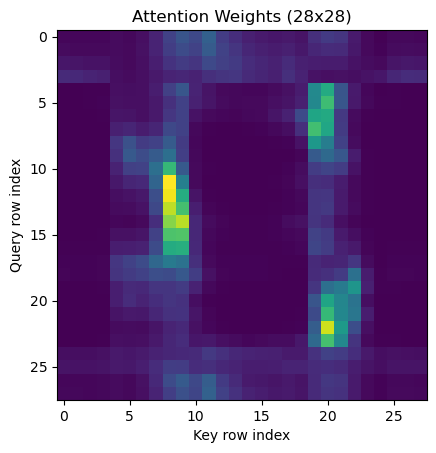

In [21]:
# =====================================
# Exercise 1: attention on multiple samples
# =====================================
for idx in [0, 1, 2, 3]:
    print("\n--- sample_index =", idx, "---")
    show_attention_and_stats(model_base, test_loader, sample_index=idx)


# Exercise 1 write-up

Only the digit 1 has higher entropy than the rest, I'd guess this is because its image matches many other parts of other numerals, so context from the entire image is necessary to discriminate it. For the other numerals, the entropy is lower because they have individually defining characteristics.

Epoch 01 | Train loss 0.8952, acc 0.7151 | Test loss 0.3653, acc 0.8900 | GradNorm ~ 9.11
Epoch 02 | Train loss 0.2903, acc 0.9144 | Test loss 0.2071, acc 0.9378 | GradNorm ~ 5.33
Epoch 03 | Train loss 0.2000, acc 0.9392 | Test loss 0.1870, acc 0.9418 | GradNorm ~ 6.12
Epoch 04 | Train loss 0.1633, acc 0.9509 | Test loss 0.1422, acc 0.9577 | GradNorm ~ 4.53
Epoch 05 | Train loss 0.1418, acc 0.9556 | Test loss 0.1169, acc 0.9645 | GradNorm ~ 5.70
Epoch 06 | Train loss 0.1278, acc 0.9607 | Test loss 0.1374, acc 0.9556 | GradNorm ~ 4.50
Epoch 07 | Train loss 0.1164, acc 0.9641 | Test loss 0.1100, acc 0.9647 | GradNorm ~ 4.74
Epoch 08 | Train loss 0.1099, acc 0.9649 | Test loss 0.1129, acc 0.9643 | GradNorm ~ 5.23
Epoch 09 | Train loss 0.1033, acc 0.9681 | Test loss 0.1000, acc 0.9699 | GradNorm ~ 3.22
Epoch 10 | Train loss 0.0999, acc 0.9690 | Test loss 0.0922, acc 0.9713 | GradNorm ~ 3.94
Label: 7  Pred: 7
Attention entropy (avg over rows): 1.5736
Most attended-to row index: 9


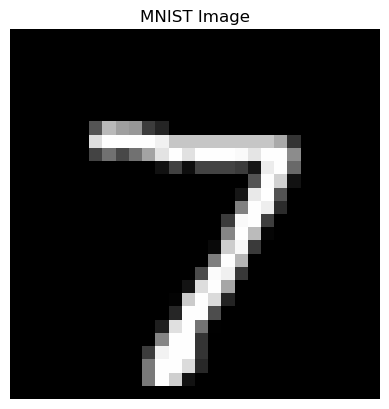

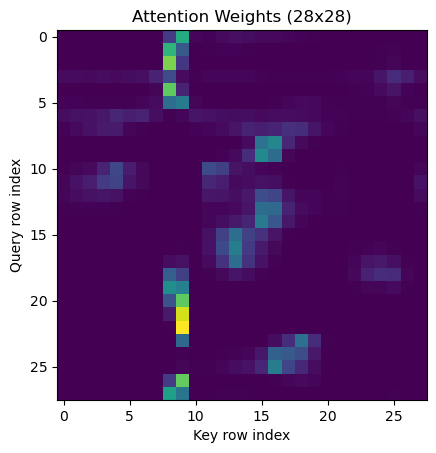

In [22]:
# =====================================
# Exercise 2: remove attention scaling (use_scale=False)
# =====================================
# =====================================
# Exercise 0: Baseline run
# =====================================
CFG = {
    "use_scale": False,
    "use_layernorm": True,
    "use_residual": True,
    "use_manual_ln": False,
    "dropout": 0.1
}

model_base = MNISTTransformer(
    d_model=64, mlp_hidden=128, dropout=CFG["dropout"],
    use_scale=CFG["use_scale"],
    use_layernorm=CFG["use_layernorm"],
    use_residual=CFG["use_residual"],
    use_manual_ln=CFG["use_manual_ln"]
)

train(model_base, train_loader, test_loader, epochs=10, lr=1e-3)
show_attention_and_stats(model_base, test_loader, sample_index=0)


# Exercise 2 write-up

Removing scaling makes the attention peaky because the learned parameters must compensate for changes in scale, instead of operating on normalized inputs as is standard for other layers.

Epoch 01 | Train loss 1.0671, acc 0.6446 | Test loss 0.5557, acc 0.8247 | GradNorm ~ 4.97
Epoch 02 | Train loss 0.4659, acc 0.8540 | Test loss 0.3422, acc 0.8942 | GradNorm ~ 4.21
Epoch 03 | Train loss 0.3156, acc 0.9022 | Test loss 0.2545, acc 0.9196 | GradNorm ~ 5.65
Epoch 04 | Train loss 0.2488, acc 0.9239 | Test loss 0.2038, acc 0.9388 | GradNorm ~ 3.60
Epoch 05 | Train loss 0.2041, acc 0.9371 | Test loss 0.1739, acc 0.9474 | GradNorm ~ 5.04
Epoch 06 | Train loss 0.1741, acc 0.9472 | Test loss 0.1582, acc 0.9507 | GradNorm ~ 6.83
Epoch 07 | Train loss 0.1578, acc 0.9513 | Test loss 0.1341, acc 0.9586 | GradNorm ~ 4.02
Epoch 08 | Train loss 0.1425, acc 0.9567 | Test loss 0.1348, acc 0.9599 | GradNorm ~ 4.16
Epoch 09 | Train loss 0.1324, acc 0.9594 | Test loss 0.1288, acc 0.9602 | GradNorm ~ 2.38
Epoch 10 | Train loss 0.1205, acc 0.9625 | Test loss 0.0975, acc 0.9701 | GradNorm ~ 4.02
Label: 7  Pred: 7
Attention entropy (avg over rows): 2.23
Most attended-to row index: 11


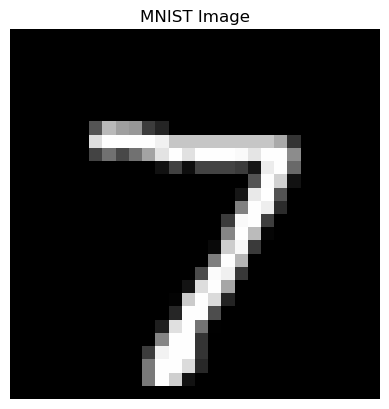

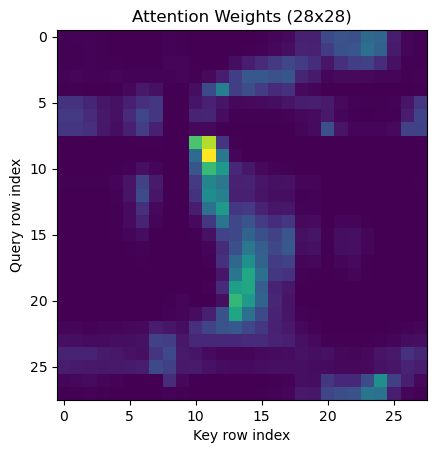

In [23]:
# =====================================
# Exercise 3: remove LayerNorm (use_layernorm=False)
# =====================================

# =====================================
# Exercise 0: Baseline run
# =====================================
CFG = {
    "use_scale": True,
    "use_layernorm": False,
    "use_residual": True,
    "use_manual_ln": False,
    "dropout": 0.1
}

model_base = MNISTTransformer(
    d_model=64, mlp_hidden=128, dropout=CFG["dropout"],
    use_scale=CFG["use_scale"],
    use_layernorm=CFG["use_layernorm"],
    use_residual=CFG["use_residual"],
    use_manual_ln=CFG["use_manual_ln"]
)

train(model_base, train_loader, test_loader, epochs=10, lr=1e-3)
show_attention_and_stats(model_base, test_loader, sample_index=0)

# Exercise 3 write-up
Layernorm helps stabilize the activations of the network, ensuring that gradients are consistent while the model is training.

Epoch 01 | Train loss 1.1052, acc 0.6286 | Test loss 0.6377, acc 0.7923 | GradNorm ~ 10.81
Epoch 02 | Train loss 0.5037, acc 0.8402 | Test loss 0.3489, acc 0.8908 | GradNorm ~ 9.40
Epoch 03 | Train loss 0.3281, acc 0.8984 | Test loss 0.2712, acc 0.9167 | GradNorm ~ 11.01
Epoch 04 | Train loss 0.2419, acc 0.9264 | Test loss 0.1919, acc 0.9395 | GradNorm ~ 10.33
Epoch 05 | Train loss 0.1953, acc 0.9401 | Test loss 0.1717, acc 0.9457 | GradNorm ~ 10.32
Epoch 06 | Train loss 0.1689, acc 0.9474 | Test loss 0.1489, acc 0.9547 | GradNorm ~ 8.23
Epoch 07 | Train loss 0.1521, acc 0.9525 | Test loss 0.1316, acc 0.9601 | GradNorm ~ 7.07
Epoch 08 | Train loss 0.1356, acc 0.9579 | Test loss 0.1236, acc 0.9628 | GradNorm ~ 6.26
Epoch 09 | Train loss 0.1300, acc 0.9596 | Test loss 0.1534, acc 0.9542 | GradNorm ~ 10.19
Epoch 10 | Train loss 0.1214, acc 0.9623 | Test loss 0.1257, acc 0.9608 | GradNorm ~ 4.73
Label: 7  Pred: 7
Attention entropy (avg over rows): 2.3357
Most attended-to row index: 6


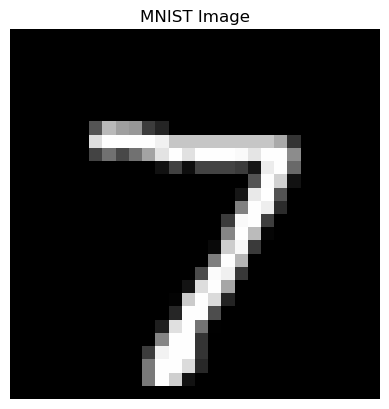

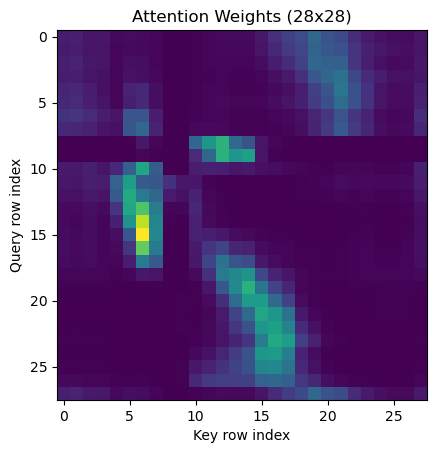

In [24]:
# =====================================
# Exercise 4: remove residuals (use_residual=False)
# =====================================
# =====================================
# Exercise 0: Baseline run
# =====================================
CFG = {
    "use_scale": True,
    "use_layernorm": True,
    "use_residual": False,
    "use_manual_ln": False,
    "dropout": 0.1
}

model_base = MNISTTransformer(
    d_model=64, mlp_hidden=128, dropout=CFG["dropout"],
    use_scale=CFG["use_scale"],
    use_layernorm=CFG["use_layernorm"],
    use_residual=CFG["use_residual"],
    use_manual_ln=CFG["use_manual_ln"]
)

train(model_base, train_loader, test_loader, epochs=10, lr=1e-3)
show_attention_and_stats(model_base, test_loader, sample_index=0)

# Exercise 4 write-up
Residual connections make training significantly easier, as it is more difficult for deeper layers to accidentally destroy information extracted in earlier layers. The default, that's preferred by weight decay, is the identity operation, making gradients much more stable.

Epoch 01 | Train loss 0.8600, acc 0.7297 | Test loss 0.3260, acc 0.9050 | GradNorm ~ 3.83
Epoch 02 | Train loss 0.2855, acc 0.9142 | Test loss 0.2002, acc 0.9379 | GradNorm ~ 6.08
Epoch 03 | Train loss 0.2032, acc 0.9384 | Test loss 0.1631, acc 0.9505 | GradNorm ~ 5.64
Epoch 04 | Train loss 0.1662, acc 0.9501 | Test loss 0.1261, acc 0.9607 | GradNorm ~ 5.17
Epoch 05 | Train loss 0.1457, acc 0.9553 | Test loss 0.1268, acc 0.9591 | GradNorm ~ 5.87
Epoch 06 | Train loss 0.1283, acc 0.9600 | Test loss 0.1052, acc 0.9664 | GradNorm ~ 4.67
Epoch 07 | Train loss 0.1165, acc 0.9631 | Test loss 0.1004, acc 0.9674 | GradNorm ~ 4.01
Epoch 08 | Train loss 0.1074, acc 0.9663 | Test loss 0.0983, acc 0.9681 | GradNorm ~ 4.40
Epoch 09 | Train loss 0.0986, acc 0.9691 | Test loss 0.0873, acc 0.9743 | GradNorm ~ 5.28
Epoch 10 | Train loss 0.0947, acc 0.9701 | Test loss 0.0952, acc 0.9678 | GradNorm ~ 2.81
Label: 7  Pred: 7
Attention entropy (avg over rows): 2.6926
Most attended-to row index: 9


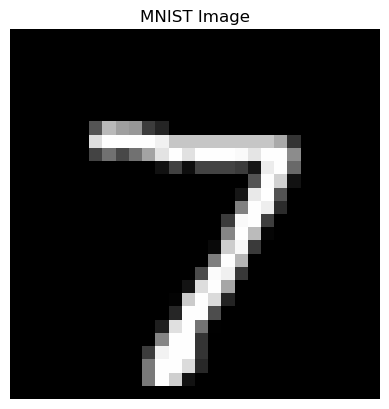

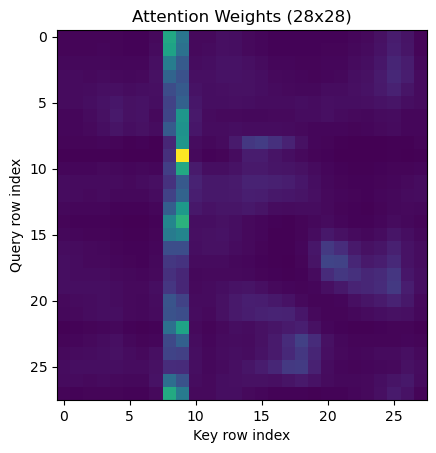

In [25]:
# =====================================
# Exercise 5: manual LayerNorm (use_manual_ln=True)
# =====================================
# =====================================
# Exercise 0: Baseline run
# =====================================
CFG = {
    "use_scale": True,
    "use_layernorm": True,
    "use_residual": True,
    "use_manual_ln": True,
    "dropout": 0.1
}

model_base = MNISTTransformer(
    d_model=64, mlp_hidden=128, dropout=CFG["dropout"],
    use_scale=CFG["use_scale"],
    use_layernorm=CFG["use_layernorm"],
    use_residual=CFG["use_residual"],
    use_manual_ln=CFG["use_manual_ln"]
)

train(model_base, train_loader, test_loader, epochs=10, lr=1e-3)
show_attention_and_stats(model_base, test_loader, sample_index=0)

# Exercise 5 write-up
Results should match baseline (and they do), differences would imply that LayerNorm works differently than the manual implementation under the hood, which would be unexpected.